# 로지스틱 회귀 분석

### step 0 패키지 불러오기

In [1]:
# 데이터 구성: Series, DataFrame
import pandas as pd

# 행렬 연산
import numpy as np

# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib

# scaling
from sklearn.preprocessing import StandardScaler

# 데이터 분할:train, test
from sklearn.model_selection import train_test_split

# 로지스틱 회귀
from statsmodels.api import Logit

# 평가 함수
from sklearn.metrics import accuracy_score

# confusion matrix
from sklearn.metrics import confusion_matrix

### step 1 데이터 구상하기

In [42]:
df_raw = pd.read_csv("./HMEQ.csv")
df_raw

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3743,0,88900,57264,90185.0,DebtCon,Other,16.0,0,0.0,221.808717,0.0,16,36.112347
3744,0,89000,54576,92937.0,DebtCon,Other,16.0,0,0.0,208.692070,0.0,15,35.859971
3745,0,89200,54045,92924.0,DebtCon,Other,15.0,0,0.0,212.279697,0.0,15,35.556590
3746,0,89800,50370,91861.0,DebtCon,Other,14.0,0,0.0,213.892709,0.0,16,34.340882


### step 2 데이터 전처리 - 결측치 처리

In [3]:
# 결측치 확인
df_raw.isnull().sum(axis = 0)

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

In [4]:
# fillna: 결측치 대체 함수
# JOB 변수의 결측치는 "Other"로 대체, inplace:fillna 함수 적용 후 df_raw 데이터에 저장, False면 저장 안함
df_raw["JOB"].fillna("Other", inplace = True)
# 숫자형 변수의 결측치는 해당 변수의 평균값 입력: df_raw.mean() 각 변수별 평균 계산 후 결측치 대체
df_raw.fillna(df_raw.mean(), inplace = True)

### 데이터 분할 (train, test 데이터 7:3 비율로 분할)

In [5]:
# train_test_split(데이터, test_size = test 데이터 비율, random_state: 랜덤)
df_train, df_test = train_test_split(df_raw, # 데이터
                                     test_size = 0.3, #test 데이터의 비율
                                     random_state = 1234) # random state

print("train data size: {}".format(df_train.shape))
print("test data size: {}".format(df_test.shape))

train data size: (2623, 13)
test data size: (1125, 13)


### step 3 모델 및 회귀계수 검토

In [6]:
# from_formula 함수를 이용하여 변수 역할 지정
# 분석 대상 이벤트 = "1"
log_model = Logit.from_formula("""BAD ~ LOAN + MORTDUE + VALUE + C(REASON) + C(JOB) + YOJ +DEROG + 
                                    DELINQ + CLAGE + NINQ + CLNO + DEBTINC """, df_train)

# 적합
log_result = log_model.fit()
# 결과 출력
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.237614
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 2623
Model:                          Logit   Df Residuals:                     2606
Method:                           MLE   Df Model:                           16
Date:                Mon, 10 Feb 2020   Pseudo R-squ.:                  0.2257
Time:                        14:17:39   Log-Likelihood:                -623.26
converged:                       True   LL-Null:                       -804.91
Covariance Type:            nonrobust   LLR p-value:                 1.743e-67
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -5.0942      0.560     -9.100      0.000      -6.191      -3.997

### step 4 예측 및 성능 평가
### 예측

In [7]:
# test 데이터 예측
y_pred = log_result.predict(df_test)
# 0과 1의 값을 가진 class 변환
y_pred_class = (y_pred > 0.5).astype(int)
y_pred_class.head()

1721    0
822     0
1686    0
789     0
165     0
dtype: int64

### 평가

In [8]:
# 실제 test 데이터의 목표변수와 test 데이터의 예측값 비교
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_test["BAD"], y_pred_class)))
print("Confustion Matrix: \n{}".format(confusion_matrix(df_test["BAD"], y_pred_class)))

Accuracy: 0.924

Confustion Matrix: 
[[1017    4]
 [  81   23]]


### step 5 결론 도출 - 최종 회귀식

In [9]:
print(log_result.summary())

                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 2623
Model:                          Logit   Df Residuals:                     2606
Method:                           MLE   Df Model:                           16
Date:                Mon, 10 Feb 2020   Pseudo R-squ.:                  0.2257
Time:                        14:17:39   Log-Likelihood:                -623.26
converged:                       True   LL-Null:                       -804.91
Covariance Type:            nonrobust   LLR p-value:                 1.743e-67
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -5.0942      0.560     -9.100      0.000      -6.191      -3.997
C(REASON)[T.HomeImp]    -0.0080      0.176     -0.045      0.964      -0.354       0.338
C(JOB)[T.Off

/home/pirl/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/pirl/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


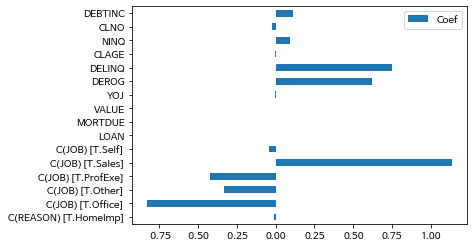

In [10]:
# 설명변수 중요도
df_logistic_coef = pd.DataFrame({"Coef": log_result.params.values[1:]}, index = log_model.exog_names[1:])
df_logistic_coef.plot.barh(y = "Coef")

### 결론 도출 - 표준화 회귀 계수

In [11]:
# select_dtypes: 특정 변수 타입을 선택/제외하여 데이터 추출
df_char = df_raw.select_dtypes(include = "object")
df_numeric = df_raw.select_dtypes(exclude = "object")

# Data Scaling
scaler = StandardScaler()
np_numeric_scaled = scaler.fit_transform(df_numeric)
df_numeric_scaled = pd.DataFrame(np_numeric_scaled, columns = df_numeric.columns)

# 문자 데이터 + 숫자 데이터
df_scaled = pd.concat([df_numeric_scaled, df_char], axis = 1)
df_scaled.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON,JOB
0,3.140664,-1.559587,-0.993626,-1.224910,-0.017563,-0.267462,-0.342558,-0.967342,-0.018776,-1.428350,0.356347,HomeImp,Other
1,3.140664,-1.550817,-1.039240,-1.174897,0.251809,-0.267462,-0.342558,-1.122053,-0.666629,-1.428350,0.329025,HomeImp,Other
2,-0.318404,-1.506968,0.607570,0.260973,-0.960364,-0.267462,-0.342558,-1.094930,-0.666629,-0.905133,-0.303684,HomeImp,Office
3,3.140664,-1.498198,-0.897428,-1.093133,0.386495,-0.267462,-0.342558,-1.344679,-0.018776,-0.067985,0.493725,HomeImp,Mgr
4,-0.318404,-1.498198,0.520156,0.191721,-0.690992,-0.267462,-0.342558,-1.060586,-0.666629,-0.905133,-0.531456,HomeImp,Office


In [12]:
# BAD 데이터를 0과 1로 변환, np.where(조건, 조건을 만족하는 경우, 만족하지 않는 경우)
df_scaled["BAD"] = np.where(df_scaled["BAD"]>0,1,0)
df_scaled.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON,JOB
0,1,-1.559587,-0.993626,-1.224910,-0.017563,-0.267462,-0.342558,-0.967342,-0.018776,-1.428350,0.356347,HomeImp,Other
1,1,-1.550817,-1.039240,-1.174897,0.251809,-0.267462,-0.342558,-1.122053,-0.666629,-1.428350,0.329025,HomeImp,Other
2,0,-1.506968,0.607570,0.260973,-0.960364,-0.267462,-0.342558,-1.094930,-0.666629,-0.905133,-0.303684,HomeImp,Office
3,1,-1.498198,-0.897428,-1.093133,0.386495,-0.267462,-0.342558,-1.344679,-0.018776,-0.067985,0.493725,HomeImp,Mgr
4,0,-1.498198,0.520156,0.191721,-0.690992,-0.267462,-0.342558,-1.060586,-0.666629,-0.905133,-0.531456,HomeImp,Office


In [13]:
# 데이터 분할
df_scaled_train, df_scaled_test = train_test_split(df_scaled, # 데이터
                                                   test_size = 0.3, # test 데이터의 비율
                                                   random_state = 1234) #random state

In [14]:
# from_formula 함수를 이용하여 변수 역할 지정
scaled_log_model = Logit.from_formula("""BAD ~ LOAN + MORTDUE + VALUE + C(REASON) + C(JOB) + YOJ +DEROG + 
                                    DELINQ + CLAGE + NINQ + CLNO + DEBTINC """, df_scaled_train)

# 적합
scaled_log_result = scaled_log_model.fit()

# 결과 출력
print(scaled_log_result.summary())

Optimization terminated successfully.
         Current function value: 0.237614
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 2623
Model:                          Logit   Df Residuals:                     2606
Method:                           MLE   Df Model:                           16
Date:                Mon, 10 Feb 2020   Pseudo R-squ.:                  0.2257
Time:                        14:17:40   Log-Likelihood:                -623.26
converged:                       True   LL-Null:                       -804.91
Covariance Type:            nonrobust   LLR p-value:                 1.743e-67
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -2.4815      0.205    -12.111      0.000      -2.883      -2.080

/home/pirl/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/pirl/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


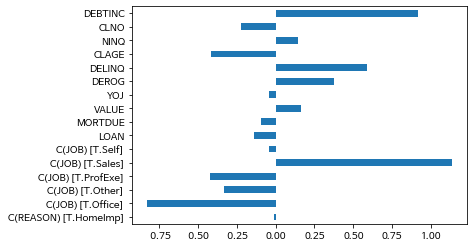

In [15]:
# 설명변수 중요도
df_logistic_coef = pd.DataFrame({"Coef": scaled_log_result.params.values[1:]}, 
                                index = scaled_log_model.exog_names[1:])
df_logistic_coef.plot.barh(y = "Coef", legend = False)

### 로지스틱 회귀분석 - 실습

In [16]:
df_raw = pd.read_csv("./통신고객이탈.csv")
df_raw

,CHURN,CUSTOMER_ID,GENDER,AGE,CHARGE_TYPE,HANDSET,USAGE_BAND,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME
0,Active,K102990,F,31,CAT 100,ASAD170,Med,33.33,6,218,379.8,9,21.6,366,632.4
1,Active,K103280,M,27,CAT 100,S50,Med,30.87,10,373,656.4,11,28.0,411,810.4
2,Active,K103660,M,27,CAT 100,ASAD170,Med,49.40,11,260,582.0,0,0.0,265,614.1
3,Active,K103730,M,61,CAT 100,ASAD170,Med,48.60,1,294,661.8,14,101.5,326,844.0
4,Active,K104560,F,52,CAT 100,S50,Med,56.03,0,221,555.6,7,25.0,274,673.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,Churned,K413330,M,19,Play 100,SOP10,Med,17.40,12,60,100.8,27,59.4,127,628.2
926,Churned,K413410,F,59,Play 100,SOP20,Med,17.37,15,82,130.2,12,25.8,357,650.7
927,Churned,K415490,F,33,Play 300,S50,Med,44.93,12,174,286.2,25,67.0,596,1039.0
928,Churned,K415880,F,25,Play 300,S50,Med,40.43,14,315,552.0,0,0.0,609,1188.3


In [26]:
# BAD 데이터를 0과 1로 변환, np.where(조건, 조건을 만족하는 경우, 만족하지 않는 경우)
df_raw["Target"] = np.where(df_raw["CHURN"]=="Active", 0,1)
df_raw.head()

,CHURN,CUSTOMER_ID,GENDER,AGE,CHARGE_TYPE,HANDSET,USAGE_BAND,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME,Target
0,Active,K102990,F,31,CAT 100,ASAD170,Med,33.33,6,218,379.8,9,21.6,366,632.4,0
1,Active,K103280,M,27,CAT 100,S50,Med,30.87,10,373,656.4,11,28.0,411,810.4,0
2,Active,K103660,M,27,CAT 100,ASAD170,Med,49.40,11,260,582.0,0,0.0,265,614.1,0
3,Active,K103730,M,61,CAT 100,ASAD170,Med,48.60,1,294,661.8,14,101.5,326,844.0,0
4,Active,K104560,F,52,CAT 100,S50,Med,56.03,0,221,555.6,7,25.0,274,673.0,0


In [27]:
df_raw["USAGE_BAND"].unique()

array(['Med', 'MedHigh', 'High', 'MedLow', 'Low', 'None'], dtype=object)

In [28]:
# 결측치 확인
df_raw.isnull().sum(axis = 0)

CHURN                 0
CUSTOMER_ID           0
GENDER                0
AGE                   0
CHARGE_TYPE           0
HANDSET               0
USAGE_BAND            0
SERVICE_DURATION      0
DROPPED_CALLS         0
PEAK_CALLS_NO         0
PEAK_CALLS_TIME       0
WEEKEND_CALLS_NO      0
WEEKEND_CALLS_TIME    0
TOTAL_CALLS_NO        0
TOTAL_CALLS_TIME      0
Target                0
dtype: int64

In [29]:
# train_test_split(데이터, test_size = test 데이터 비율, random_state: 랜덤)
df_train, df_test = train_test_split(df_raw, # 데이터
                                     test_size = 0.3, #test 데이터의 비율
                                     random_state = 1234) # random state

print("train data size: {}".format(df_train.shape))
print("test data size: {}".format(df_test.shape))

train data size: (651, 16)
test data size: (279, 16)


In [30]:
df_train.tail()

,CHURN,CUSTOMER_ID,GENDER,AGE,CHARGE_TYPE,HANDSET,USAGE_BAND,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME,Target
204,Active,K167310,F,15,CAT 100,ASAD170,Med,20.63,11,270,708.6,0,0.0,299,765.6,0
53,Active,K120070,F,40,CAT 200,S50,MedHigh,32.47,2,425,979.2,11,65.4,587,1293.9,0
294,Active,K249140,F,55,Play 300,BS110,Med,36.83,1,86,334.8,0,0.0,93,1226.7,0
723,Active,K388540,M,30,Play 300,S80,Med,35.57,1,285,510.0,2,5.4,692,1197.3,0
815,Churned,K209850,M,21,Play 300,ASAD90,Med,43.17,0,25,429.0,6,10.5,192,946.2,1


In [33]:
# from_formula 함수를 이용하여 변수 역할 지정
# 분석 대상 이벤트 = "1"
log_model = Logit.from_formula("""Target ~C(GENDER) + AGE +  C(CHARGE_TYPE) + C(HANDSET) + C(USAGE_BAND) +SERVICE_DURATION + 
                                    DROPPED_CALLS + PEAK_CALLS_NO + PEAK_CALLS_TIME + WEEKEND_CALLS_NO + WEEKEND_CALLS_TIME + TOTAL_CALLS_NO + TOTAL_CALLS_TIME """, df_train)

# 적합
log_result = log_model.fit()
# 결과 출력
print(log_result.summary())

         Current function value: 0.253230
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 Target   No. Observations:                  651
Model:                          Logit   Df Residuals:                      621
Method:                           MLE   Df Model:                           29
Date:                Mon, 10 Feb 2020   Pseudo R-squ.:                  0.5059
Time:                        14:23:33   Log-Likelihood:                -164.85
converged:                      False   LL-Null:                       -333.64
Covariance Type:            nonrobust   LLR p-value:                 2.736e-54
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    -24.1056   2065.436     -0.012      0.991   -4072.286    4024.075
C(GENDER)[T.M]   

/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


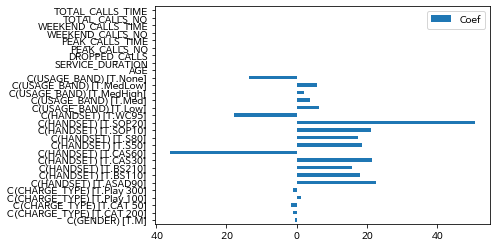

In [34]:
# 설명변수 중요도
df_logistic_coef = pd.DataFrame({"Coef": log_result.params.values[1:]}, index = log_model.exog_names[1:])
df_logistic_coef.plot.barh(y = "Coef")

In [36]:
# select_dtypes: 특정 변수 타입을 선택/제외하여 데이터 추출
df_char = df_raw.select_dtypes(include = "object")
df_numeric = df_raw.select_dtypes(exclude = "object")

# Data Scaling
scaler = StandardScaler()
np_numeric_scaled = scaler.fit_transform(df_numeric)
df_numeric_scaled = pd.DataFrame(np_numeric_scaled, columns = df_numeric.columns)

# 문자 데이터 + 숫자 데이터
df_scaled = pd.concat([df_numeric_scaled, df_char], axis = 1)
df_scaled.head()

,AGE,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME,Target,CHURN,CUSTOMER_ID,GENDER,CHARGE_TYPE,HANDSET,USAGE_BAND
0,-0.030604,-0.069958,0.949112,-0.032834,-0.617357,-0.432263,-0.755024,0.079015,-0.783880,-0.489898,Active,K102990,F,CAT 100,ASAD170,Med
1,-0.335827,-0.243451,2.091732,0.651830,-0.080674,-0.307456,-0.579614,0.259163,-0.458260,-0.489898,Active,K103280,M,CAT 100,S50,Med
2,-0.335827,1.063386,2.377387,0.152687,-0.225031,-0.993897,-1.347031,-0.325316,-0.817357,-0.489898,Active,K103660,M,CAT 100,ASAD170,Med
3,2.258568,1.006966,-0.479163,0.302872,-0.070196,-0.120245,1.434855,-0.081116,-0.396795,-0.489898,Active,K103730,M,CAT 100,ASAD170,Med
4,1.571816,1.530970,-0.764818,-0.019583,-0.276254,-0.557071,-0.661838,-0.289287,-0.709610,-0.489898,Active,K104560,F,CAT 100,S50,Med


In [37]:
# Target 데이터를 0과 1로 변환, np.where(조건, 조건을 만족하는 경우, 만족하지 않는 경우)
df_scaled["Target"] = np.where(df_scaled["Target"]>0,1,0)
df_scaled.head()

,AGE,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME,Target,CHURN,CUSTOMER_ID,GENDER,CHARGE_TYPE,HANDSET,USAGE_BAND
0,-0.030604,-0.069958,0.949112,-0.032834,-0.617357,-0.432263,-0.755024,0.079015,-0.783880,0,Active,K102990,F,CAT 100,ASAD170,Med
1,-0.335827,-0.243451,2.091732,0.651830,-0.080674,-0.307456,-0.579614,0.259163,-0.458260,0,Active,K103280,M,CAT 100,S50,Med
2,-0.335827,1.063386,2.377387,0.152687,-0.225031,-0.993897,-1.347031,-0.325316,-0.817357,0,Active,K103660,M,CAT 100,ASAD170,Med
3,2.258568,1.006966,-0.479163,0.302872,-0.070196,-0.120245,1.434855,-0.081116,-0.396795,0,Active,K103730,M,CAT 100,ASAD170,Med
4,1.571816,1.530970,-0.764818,-0.019583,-0.276254,-0.557071,-0.661838,-0.289287,-0.709610,0,Active,K104560,F,CAT 100,S50,Med


In [38]:
# 데이터 분할
df_scaled_train, df_scaled_test = train_test_split(df_scaled, # 데이터
                                                   test_size = 0.3, # test 데이터의 비율
                                                   random_state = 1234) #random state

In [39]:
# from_formula 함수를 이용하여 변수 역할 지정
scaled_log_model = Logit.from_formula("""Target ~C(GENDER) + AGE +  C(CHARGE_TYPE) + C(HANDSET) + C(USAGE_BAND) +SERVICE_DURATION + 
                                    DROPPED_CALLS + PEAK_CALLS_NO + PEAK_CALLS_TIME + WEEKEND_CALLS_NO + WEEKEND_CALLS_TIME + TOTAL_CALLS_NO + TOTAL_CALLS_TIME """, df_scaled_train)

# 적합
scaled_log_result = scaled_log_model.fit()

# 결과 출력
print(scaled_log_result.summary())

         Current function value: 0.253230
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 Target   No. Observations:                  651
Model:                          Logit   Df Residuals:                      621
Method:                           MLE   Df Model:                           29
Date:                Mon, 10 Feb 2020   Pseudo R-squ.:                  0.5059
Time:                        14:32:37   Log-Likelihood:                -164.85
converged:                      False   LL-Null:                       -333.64
Covariance Type:            nonrobust   LLR p-value:                 2.736e-54
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    -22.6857   2065.401     -0.011      0.991   -4070.798    4025.427
C(GENDER)[T.M]   

/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/home/pirl/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/pirl/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


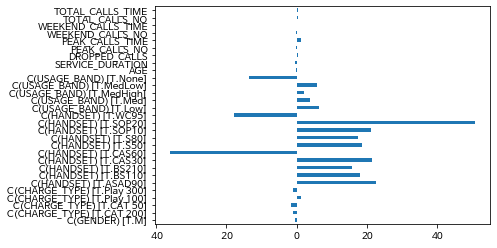

In [40]:
# 설명변수 중요도
df_logistic_coef = pd.DataFrame({"Coef": scaled_log_result.params.values[1:]}, 
                                index = scaled_log_model.exog_names[1:])
df_logistic_coef.plot.barh(y = "Coef", legend = False)